# Data Download/Transform/Augment

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms


In [2]:
import torch.utils
from torch.utils.data import DataLoader, random_split

In [3]:
data_statistics = ((0.5,0.5,0.5),(0.5,0.5,0.5) )
train_transforms_cifar = transforms.Compose ([
    transforms.RandomCrop(32, padding=4, padding_mode = 'reflect'),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(*data_statistics , inplace = True)
                                             ])

In [4]:
test_transforms_cifar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(*data_statistics, inplace =True)
                                            ])

In [5]:
dataset = torchvision.datasets.CIFAR10( root = "data/" , download = True, transform = train_transforms_cifar)
test_dataset = torchvision.datasets.CIFAR10(root ="data/" , download= True, train= False, transform= test_transforms_cifar )

100%|██████████| 170498071/170498071 [00:05<00:00, 32608033.09it/s]


Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified


In [6]:
batch_size = 32
val_ratio = 0.2
train_dataset , val_dataset = random_split(dataset, [int((1-val_ratio) * len(dataset)), int(val_ratio* len(dataset))])
train_dl = DataLoader(train_dataset, batch_size, shuffle=True, pin_memory = True)
val_dl = DataLoader(val_dataset, batch_size,shuffle = True, pin_memory = True)
test_dl = DataLoader(test_dataset, batch_size , shuffle = True, pin_memory = True)

In [7]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

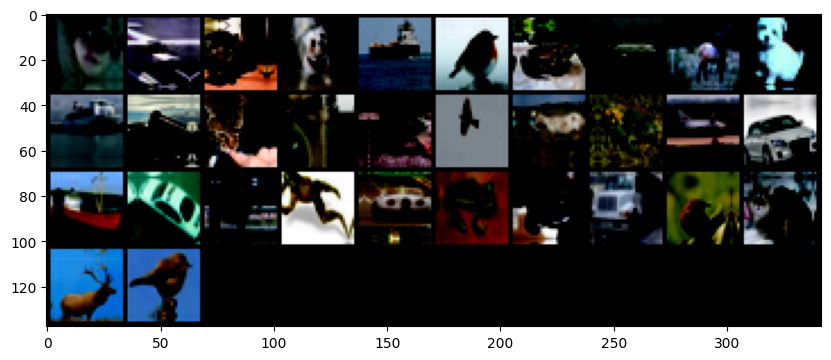

In [8]:
def show_batch(dl):
  for images,labels in dl:
    fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(make_grid(images,10).permute(1,2,0)) #HWC
    break
show_batch(train_dl)

# Network Architecture


In [9]:
import torch.nn as nn

In [10]:
def conv_block(in_channels, out_channels, pool =False):
  layers =[nn.Conv2d(in_channels,out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels) ,
           nn.ReLU(inplace = True)]
  if pool:
    layers.append(nn.MaxPool2d(2))
  return nn.Sequential(*layers)

class ResnetX(nn.Module):
  def __init__(self, in_channels, num_classes):
    super().__init__()
    self.conv1 = conv_block(in_channels,64)
    self.conv2 = conv_block(64,128, pool = True)
    self.res1 = nn.Sequential(conv_block(128,128), conv_block(128,128))

    self.conv3 = conv_block(128,256, pool = True)
    self.conv4 = conv_block(256,512, pool= True)
    self.res2 = nn.Sequential(conv_block(512,512), conv_block(512,512))

    self.classifier = nn.Sequential( nn.MaxPool2d(4),
                                  nn.Flatten(),
                                   nn.Dropout(0.2),
                                   nn.Linear(512,num_classes)
                                  )

  def forward(self, x):
    out = self.conv1(x)
    out = self.conv2(out)
    out = self.res1(out) + out
    out = self.conv3(out)
    out=self.conv4(out)
    out= self.res2(out) + out
    return self.classifier(out)



# Models

In [31]:
model = ResnetX(3,10)
model

ResnetX(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [ ]:
model = torchvision.models.resnet50(pretrained=True)

# Replace the last fully connected layer with a one suitable for CIFAR-10
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


ResnetX(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

# Train


In [33]:
criterion = nn.CrossEntropyLoss()
import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


In [14]:
train_losses = []
test_losses = []
train_accs = []
test_accs = []


In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_dl:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        running_loss += loss.item()

    train_loss = running_loss / len(train_dl)
    train_acc = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Testing
    model.eval()
    running_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for inputs, labels in test_dl:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

            running_loss += loss.item()

    test_loss = running_loss / len(test_dl)
    test_acc = 100 * correct_test / total_test
    test_losses.append(test_loss)
    test_accs.append(test_acc)



    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
          f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')


In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accs, label='Train Acc')
plt.plot(range(1, num_epochs + 1), test_accs, label='Test Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Train with waiting epochs


In [ ]:
criterion = nn.CrossEntropyLoss()
import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Epoch [1/50], Train Loss: 1.6848, Train Acc: 43.02%, Val Loss: 1.1809, Val Acc: 57.47%
Saving the model...
Epoch [2/50], Train Loss: 1.2152, Train Acc: 58.49%, Val Loss: 0.9360, Val Acc: 66.37%
Saving the model...
Epoch [3/50], Train Loss: 1.0020, Train Acc: 65.79%, Val Loss: 0.9724, Val Acc: 65.62%
Epoch [4/50], Train Loss: 0.8969, Train Acc: 69.66%, Val Loss: 0.8918, Val Acc: 69.85%
Saving the model...
Epoch [5/50], Train Loss: 0.7970, Train Acc: 73.06%, Val Loss: 0.9115, Val Acc: 70.38%
Saving the model...
Epoch [6/50], Train Loss: 0.7379, Train Acc: 75.00%, Val Loss: 0.5892, Val Acc: 79.29%
Saving the model...
Epoch [7/50], Train Loss: 0.6720, Train Acc: 77.14%, Val Loss: 0.6834, Val Acc: 77.37%
Epoch [8/50], Train Loss: 0.6341, Train Acc: 78.73%, Val Loss: 0.6704, Val Acc: 77.57%
Epoch [9/50], Train Loss: 0.5974, Train Acc: 79.85%, Val Loss: 0.5560, Val Acc: 80.93%
Saving the model...
Epoch [10/50], Train Loss: 0.5513, Train Acc: 81.47%, Val Loss: 0.5088, Val Acc: 83.09%
Saving th

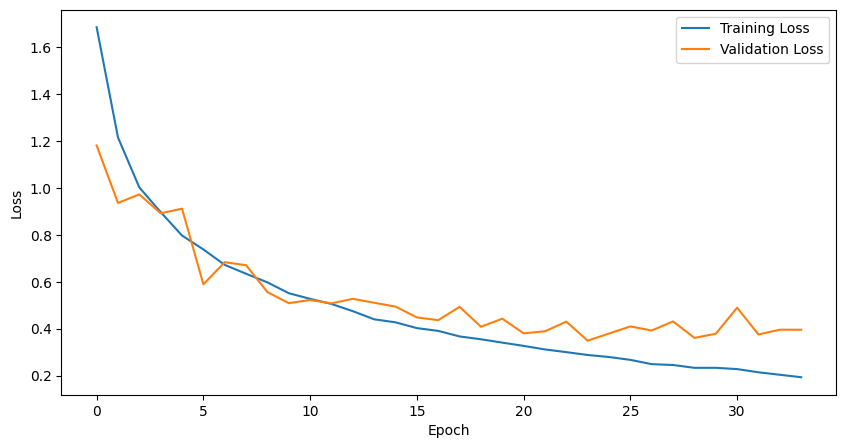

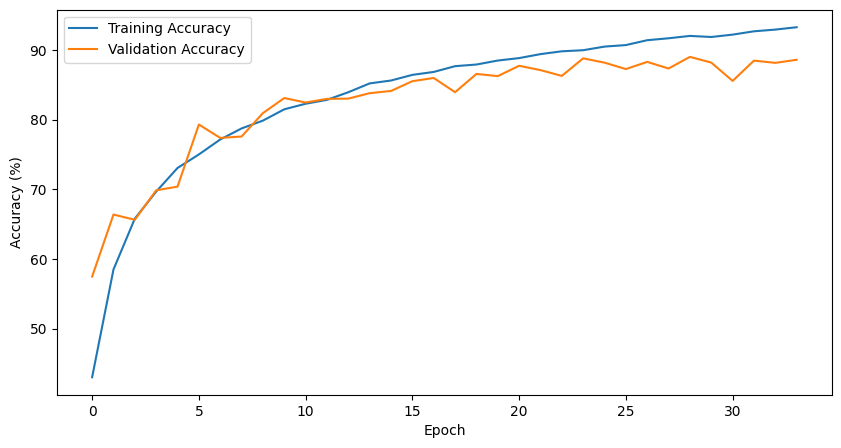

In [34]:

best_accuracy = 0.0
wait_counter = 0
train_losses = []
val_losses = []
train_accs = []
val_accs = []
num_epochs = 50
waiting_epochs = 5

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    train_total = 0
    train_correct = 0

    for images, labels in train_dl:
        images = images.to(device)
        labels = labels.to(device)



        # forward
        outputs = model(images)
        loss = criterion(outputs, labels)

        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # compute training accuracy
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        train_loss += loss.item()

    train_accuracy = 100.0 * train_correct / train_total
    train_losses.append(train_loss / len(train_dl))
    train_accs.append(train_accuracy)

    # validation
    model.eval()
    val_loss = 0.0
    val_total = 0
    val_correct = 0

    with torch.no_grad():
        for images, labels in val_dl:
            images = images.to(device)
            labels = labels.to(device)

            # forward
            outputs = model(images)
            loss = criterion(outputs, labels)

            # validation accuracy
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            val_loss += loss.item()

    val_accuracy = 100.0 * val_correct / val_total
    val_losses.append(val_loss / len(val_dl))
    val_accs.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.2f}%, "
          f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accs[-1]:.2f}%")

    # checking for improvement in validation accuracy
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        wait_counter = 0
        torch.save(model.state_dict(), "resnet_best_model3.pth")
        print("Saving the model...")

    else:
        wait_counter += 1
        if wait_counter >= waiting_epochs:
            print("No improvement in validation accuracy. Training stopped.")
            break

# Plot
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()


In [1]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

NameError: ignored